In [1]:
#Importing packages
from selenium import webdriver
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain
nltk.download('punkt')
nltk.download('wordnet')

import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tsblo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tsblo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Summary of changes after meeting on 11/1
1. Used inverse of lift to MDS (align with the slides)
2. Fixed random_state in MDS (you can change it and see which works the best for you)
3. Completed task C
4. Completed task E, you can change the words in the list and see what happens

## Scraper
First of all, don't run it!, it took me hours to scrape all the data (It should not have taken so long but I don't know why).

Secondly, I scraped around 7500 most recent pieces of comment instead of 5000 because the most recent 5000 comments are contributed by 68 users. With 7500 comments, we can get opioins from 130 users, which diversifys our data.

In [2]:
# %%time

# #change directory where you put your chrome driver
# options = webdriver.ChromeOptions()
# options.add_argument('headless')
# driver = webdriver.Chrome("chromedriver", options=options)

# all_comments = pd.DataFrame(columns = ['Date','user_id', 'comments']) 

# x = 284
# pages_scraped = 434
# driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}'.format(x))

# while x <= pages_scraped:
#     print("page",x)
    
#     if x > 1:
#         driver.find_element_by_link_text("{}".format(x)).click()
#         driver.implicitly_wait(3)
    
#     ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
#     comment_ids = []
#     for i in ids:
#         comment_ids.append(i.get_attribute('id'))

#     for d in comment_ids:

#         #Extract dates from for each user on a page
#         user_date = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
#         date = user_date.get_attribute('title')

#         #Extract user ids from each user on a page
#         userid_element = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
#         userid = userid_element.text

#         #Extract Message for each user on a page
#         if driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/p'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/p')[0]
#             comment = user_message.text
#         elif driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/ul/li'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/ul/li')[0]
#             comment = user_message.text
#         elif driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]')[0]
#             comment = user_message.text
#         else: 
#             comment = None
        
#         #Adding date, userid and comment for each user in a dataframe    
#         all_comments.loc[len(all_comments)] = [date,userid,comment]
        
#     x += 1

In [3]:
# all_comments.to_csv("7500_comments_edmunds.csv", sep="\t")

## Check the data
We have 7506 rows of comments from 2012-8-10 to 2019-8-21, comtibuted by 130 users.

In [4]:
df = pd.read_csv("7500_comments_edmunds.csv", sep="\t", parse_dates=['Date'])
df = df[['Date', 'user_id', 'comments']]
df = df.dropna()

In [5]:
df.shape

(7506, 3)

In [6]:
df['Date'].max()

Timestamp('2019-08-21 02:25:00')

In [7]:
df['Date'].min()

Timestamp('2012-08-10 01:45:00')

In [8]:
len(df['user_id'].value_counts())

130

### Preprocess comments

In [9]:
%%time
# tokenization = split sentences into word strings
df['tokens'] = df['comments'].map(nltk.word_tokenize)
df['tokens'] = df['tokens'].map(lambda x: set(x))

# lemmatization = converting a word to its base form, different from stemming
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 8.5 s


## Replace model to brand

In [10]:
%%time
models = pd.read_csv("models (5).csv", header = None)
models.columns = ['brand', 'model']

## clean brand list
models.loc[(models['brand'] == 'mercedes'),'brand'] = 'mercedes-benz'
models.loc[(models['brand'] == 'kia.'),'brand'] = 'kia'

def model_to_brand(word):
    if word.lower() in models['model'].values:
        brand = models[models['model'] == word].iloc[0,0] #takes index where model == word and returns first column 
        print('replace ' + word + ' to ' + brand)
        return(brand)
    else:
        return(word)

df['processed'] = df['processed'].map(lambda x: [model_to_brand(word) for word in x])

replace 6-series to bmw
replace 4-series to bmw
replace 3-series to bmw
replace accent to hyundai
replace focus to ford
replace legacy to subaru
replace mercedes to mercedes benz
replace focus to ford
replace camry to toyota
replace colorado to chevrolet
replace cx-7 to mazda
replace quattro to audi
replace cavalier to chevrolet
replace cruiser to chrysler
replace comfort to toyota
replace a4 to audi
replace passat to volkswagen
replace lacrosse to buick
replace ilx to acura
replace a4 to audi
replace a3 to audi
replace quattro to audi
replace a4 to audi
replace a3 to audi
replace quattro to audi
replace jetta to volkswagen
replace passat to volkswagen
replace quattro to audi
replace tsx to acura
replace a3 to audi
replace quattro to audi
replace tsx to acura
replace a3 to audi
replace a4 to audi
replace ilx to acura
replace ilx to acura
replace rlx to acura
replace 328i to bmw
replace tsx to acura
replace tsx to acura
replace tsx to acura
replace tsx to acura
replace legend to acura
r

replace q5 to audi
replace mercedes to mercedes benz
replace city to honda
replace pilot to honda
replace cx-7 to mazda
replace focus to ford
replace pilot to honda
replace stellar to hyundai
replace quattro to audi
replace 328i to bmw
replace city to honda
replace a4 to audi
replace altima to nissan
replace a4 to audi
replace impala to chevrolet
replace chevy to chevrolet
replace city to honda
replace a3 to audi
replace a3 to audi
replace a4 to audi
replace quattro to audi
replace mercedes to mercedes benz
replace a6 to audi
replace a3 to audi
replace genesis to hyundai
replace a4 to audi
replace vw to volkswagen
replace ilx to acura
replace civic to honda
replace ilx to acura
replace civic to honda
replace q7 to audi
replace ilx to acura
replace rsx to acura
replace civic to honda
replace q5 to audi
replace vw to volkswagen
replace q7 to audi
replace pony to hyundai
replace rsx to acura
replace civic to honda
replace vw to volkswagen
replace q7 to audi
replace q5 to audi
replace pony

replace m5 to bmw
replace gti to volkswagen
replace m3 to bmw
replace bmws to bmw
replace a4 to audi
replace xdrive to bmw
replace 328i to bmw
replace 528i to bmw
replace ilx to acura
replace a4 to audi
replace accords to honda
replace accord to honda
replace accord to honda
replace fusion to ford
replace ilx to acura
replace pony to hyundai
replace civic to honda
replace a3 to audi
replace golf to volkswagen
replace a6 to audi
replace a8 to audi
replace a4 to audi
replace focus to ford
replace mustang to ford
replace 370z to nissan
replace golf to volkswagen
replace ilx to acura
replace pony to hyundai
replace a3 to audi
replace a3 to audi
replace quattro to audi
replace cars to car
replace mercedes to mercedes benz
replace mdx to acura
replace focus to ford
replace quattro to audi
replace vw to volkswagen
replace a4 to audi
replace srx to cadillac
replace impala to chevrolet
replace q5 to audi
replace accord to honda
replace xc60 to volvo
replace fx35 to infiniti
replace rdx to acura

replace a3 to audi
replace q7 to audi
replace a4 to audi
replace 335i to bmw
replace 3-series to bmw
replace a4 to audi
replace c-class to mercedes-benz
replace xdrive to bmw
replace accords to honda
replace 328i to bmw
replace camrys to toyota
replace 335i to bmw
replace passats to volkswagen
replace mercedes to mercedes benz
replace nissans to nissan
replace genesis to hyundai
replace m3 to bmw
replace 5-series to bmw
replace e-class to mercedes-benz
replace m3 to bmw
replace s60 to volvo
replace 335i to bmw
replace comfort to toyota
replace 4-series to bmw
replace benz to mercedes-benz
replace e-class to mercedes-benz
replace mercedes to mercedes benz
replace s60 to volvo
replace a3 to audi
replace s60 to volvo
replace regal to buick
replace a3 to audi
replace regal to buick
replace regal to buick
replace azera to hyundai
replace regal to buick
replace avalon to toyota
replace a3 to audi
replace regal to buick
replace s60 to volvo
replace a3 to audi
replace regal to buick
replace s6

replace m6 to bmw
replace cruiser to chrysler
replace bmws to bmw
replace m6 to bmw
replace focus to ford
replace alpina to bmw
replace cruiser to chrysler
replace m6 to bmw
replace focus to ford
replace cruiser to chrysler
replace bmws to bmw
replace m6 to bmw
replace mdx to acura
replace gti to volkswagen
replace vw to volkswagen
replace ilx to acura
replace nsx to honda
replace escalade to cadillac
replace bmws to bmw
replace pony to hyundai
replace city to honda
replace comfort to toyota
replace comfort to toyota
replace quattro to audi
replace a5 to audi
replace accord to honda
replace alpina to bmw
replace alpina to bmw
replace m5 to bmw
replace focus to ford
replace focus to ford
replace amaze to honda
replace a4 to audi
replace legacy to subaru
replace amaze to honda
replace a4 to audi
replace 335d to bmw
replace charger to dodge
replace quattro to audi
replace quattro to audi
replace a6 to audi
replace genesis to hyundai
replace genesis to hyundai
replace outback to subaru
rep

replace 335i to bmw
replace toyotas to toyota
replace jetta to volkswagen
replace vw to volkswagen
replace charger to dodge
replace a3 to audi
replace vw to volkswagen
replace golf to volkswagen
replace hondas to honda
replace toyotas to toyota
replace jetta to volkswagen
replace genesis to hyundai
replace vw to volkswagen
replace jetta to volkswagen
replace wave to pontiac
replace wave to pontiac
replace jetta to volkswagen
replace challenger to dodge
replace challenger to dodge
replace jetta to volkswagen
replace challenger to dodge
replace jetta to volkswagen
replace express to chevrolet
replace challenger to dodge
replace challenger to dodge
replace wrx to subaru
replace pony to hyundai
replace challenger to dodge
replace mustang to ford
replace charger to dodge
replace challenger to dodge
replace wrx to subaru
replace q7 to audi
replace golf to volkswagen
replace vw to volkswagen
replace legacy to subaru
replace maxima to nissan
replace wave to pontiac
replace jetta to volkswagen


replace gto to pontiac
replace pony to hyundai
replace century to buick
replace a4 to audi
replace cars to car
replace a6 to audi
replace a4 to audi
replace c-class to mercedes-benz
replace c-class to mercedes-benz
replace 3-series to bmw
replace benz to mercedes-benz
replace c-class to mercedes-benz
replace 335i to bmw
replace mercedes to mercedes benz
replace c-class to mercedes-benz
replace c-class to mercedes-benz
replace benz to mercedes-benz
replace e-class to mercedes-benz
replace c-class to mercedes-benz
replace mercedes to mercedes benz
replace s-class to mercedes-benz
replace 3-series to bmw
replace mazda3 to mazda
replace comfort to toyota
replace comfort to toyota
replace c-class to mercedes-benz
replace c-class to mercedes-benz
replace focus to ford
replace xts to cadillac
replace buicks to buick
replace mercedes to mercedes benz
replace a6 to audi
replace q5 to audi
replace leaf to nissan
replace mercedes to mercedes benz
replace focus to ford
replace xts to cadillac
repl

replace vw to volkswagen
replace benz to mercedes-benz
replace vw to volkswagen
replace colorado to chevrolet
replace vw to volkswagen
replace vw to volkswagen
replace sail to chevrolet
replace vw to volkswagen
replace vw to volkswagen
replace vw to volkswagen
replace colorado to chevrolet
replace vw to volkswagen
replace vw to volkswagen
replace vw to volkswagen
replace pony to hyundai
replace jetta to volkswagen
replace jetta to volkswagen
replace rabbit to volkswagen
replace pony to hyundai
replace jetta to volkswagen
replace a3 to audi
replace vw to volkswagen
replace vw to volkswagen
replace a3 to audi
replace vw to volkswagen
replace golf to volkswagen
replace vw to volkswagen
replace a3 to audi
replace vw to volkswagen
replace golf to volkswagen
replace vws to volkswagen
replace vw to volkswagen
replace vw to volkswagen
replace vw to volkswagen
replace vw to volkswagen
replace wave to pontiac
replace vw to volkswagen
replace q3 to audi
replace a3 to audi
replace a5 to audi
repla

replace wrx to subaru
replace wrx to subaru
replace legacy to subaru
replace wrx to subaru
replace legacy to subaru
replace wrx to subaru
replace a3 to audi
replace a3 to audi
replace golf to volkswagen
replace hondas to honda
replace q50 to infiniti
replace q50 to infiniti
replace a4 to audi
replace q50 to infiniti
replace vw to volkswagen
replace vw to volkswagen
replace q50 to infiniti
replace mustang to ford
replace cars to car
replace m3 to bmw
replace comfort to toyota
replace mustang to ford
replace m3 to bmw
replace bmws to bmw
replace mustang to ford
replace challenger to dodge
replace challenger to dodge
replace bmws to bmw
replace mustang to ford
replace cars to car
replace legend to acura
replace bmws to bmw
replace legend to acura
replace q50 to infiniti
replace caliber to dodge
replace q50 to infiniti
replace q50 to infiniti
replace q50 to infiniti
replace mercedes to mercedes benz
replace a3 to audi
replace q50 to infiniti
replace s60 to volvo
replace bmws to bmw
replace

replace mercedes to mercedes benz
replace accord to honda
replace v60 to volvo
replace s60 to volvo
replace xc90 to volvo
replace s60 to volvo
replace accords to honda
replace rlx to acura
replace accord to honda
replace quattro to audi
replace a5 to audi
replace 640i to bmw
replace quattro to audi
replace a5 to audi
replace hyundais to hyundai
replace hyundais to hyundai
replace mercedes to mercedes benz
replace bmws to bmw
replace 328i to bmw
replace a4 to audi
replace quattro to audi
replace quattro to audi
replace a4 to audi
replace genesis to hyundai
replace a4 to audi
replace cruiser to chrysler
replace forte to kia
replace accords to honda
replace cr-v to honda
replace taurus to ford
replace sonata to hyundai
replace a4 to audi
replace accord to honda
replace accords to honda
replace cr-v to honda
replace taurus to ford
replace sonata to hyundai
replace a4 to audi
replace accord to honda
replace accord to honda
replace accord to honda
replace accords to honda
replace accord to h

replace comfort to toyota
replace mercedes to mercedes benz
replace benz to mercedes-benz
replace xc90 to volvo
replace wrx to subaru
replace bmws to bmw
replace v60 to volvo
replace s60 to volvo
replace v60 to volvo
replace s60 to volvo
replace rdx to acura
replace mercedes to mercedes benz
replace genesis to hyundai
replace camry to toyota
replace camry to toyota
replace camry to toyota
replace camry to toyota
replace lx to chrysler
replace rlx to acura
replace civic to honda
replace accord to honda
replace rlx to acura
replace lx to chrysler
replace rlx to acura
replace civic to honda
replace e-class to mercedes-benz
replace civic to honda
replace rlx to acura
replace accord to honda
replace rlx to acura
replace mercedes to mercedes benz
replace rlx to acura
replace accord to honda
replace sonata to hyundai
replace rlx to acura
replace rdx to acura
replace accord to honda
replace ilx to acura
replace ilx to acura
replace seats to seat
replace seats to seat
replace accord to honda
re

replace 535i to bmw
replace genesis to hyundai
replace a6 to audi
replace 328i to bmw
replace spike to honda
replace 328i to bmw
replace tsx to acura
replace genesis to hyundai
replace accord to honda
replace bmws to bmw
replace tsx to acura
replace mercedes to mercedes benz
replace escalade to cadillac
replace genesis to hyundai
replace suburban to chevrolet
replace 335i to bmw
replace m3 to bmw
replace xts to cadillac
replace vigor to acura
replace vigor to acura
replace integra to acura
replace legend to acura
replace vigor to acura
replace vigor to acura
replace legend to acura
replace 5-series to bmw
replace legend to acura
replace legend to acura
replace vigor to acura
replace legend to acura
replace accord to honda
replace integra to acura
replace legend to acura
replace nsx to honda
replace integra to acura
replace mercedes to mercedes benz
replace civic to honda
replace pilot to honda
replace mdx to acura
replace accord to honda
replace sentra to nissan
replace camry to toyota

replace viper to dodge
replace nsx to honda
replace wrx to subaru
replace 335i to bmw
replace g37 to infiniti
replace agile to chevrolet
replace focus to ford
replace golf to volkswagen
replace nsx to honda
replace nsx to honda
replace mercedes to mercedes benz
replace genesis to hyundai
replace 335i to bmw
replace cappuccino to suzuki
replace city to honda
replace bmws to bmw
replace prelude to honda
replace maxima to nissan
replace i30 to hyundai
replace m3 to bmw
replace hondas to honda
replace mdx to acura
replace chevy to chevrolet
replace i30 to hyundai
replace 328i to bmw
replace vw to volkswagen
replace m3 to bmw
replace civic to honda
replace 328i to bmw
replace 335d to bmw
replace 335d to bmw
replace 335d to bmw
replace vw to volkswagen
replace 328i to bmw
replace city to honda
replace mdx to acura
replace 335d to bmw
replace 335d to bmw
replace 335d to bmw
replace 335d to bmw
replace cruiser to chrysler
replace m3 to bmw
replace 335i to bmw
replace m3 to bmw
replace mdx to a

replace explorer to ford
replace rdx to acura
replace civic to honda
replace rx-8 to mazda
replace 3-series to bmw
replace 330ci to bmw
replace bmws to bmw
replace sienna to toyota
replace a4 to audi
replace integra to acura
replace ilx to acura
replace civic to honda
replace civic to honda
replace tsx to acura
replace civic to honda
replace wrx to subaru
replace wrx to subaru
replace 328i to bmw
replace civic to honda
replace 3-series to bmw
replace quattro to audi
replace cr-v to honda
replace rlx to acura
replace accord to honda
replace 328i to bmw
replace 335i to bmw
replace xdrive to bmw
replace pilot to honda
replace pilot to honda
replace 335d to bmw
replace buicks to buick
replace camaro to chevrolet
replace mdx to acura
replace fords to ford
replace taurus to ford
replace fords to ford
replace explorer to ford
replace colorado to chevrolet
replace colorado to chevrolet
replace jetta to volkswagen
replace cx-7 to mazda
replace mercedes to mercedes benz
replace vw to volkswagen


replace s60 to volvo
replace bmws to bmw
replace mercedes to mercedes benz
replace bmws to bmw
replace city to honda
replace xdrive to bmw
replace rlx to acura
replace 3-series to bmw
replace explorer to ford
replace city to honda
replace 3-series to bmw
replace vw to volkswagen
replace chevy to chevrolet
replace 335d to bmw
replace accords to honda
replace benz to mercedes-benz
replace 328i to bmw
replace 335i to bmw
replace mercedes to mercedes benz
replace kingdom to toyota
replace 335d to bmw
replace 328i to bmw
replace mercedes to mercedes benz
replace prius to toyota
replace 335d to bmw
replace bmws to bmw
replace crv to honda
replace focus to ford
replace explorer to ford
replace legend to acura
replace 3-series to bmw
replace benz to mercedes-benz
replace rav4 to toyota
replace escape to ford
replace rogue to nissan
replace vw to volkswagen
replace forester to subaru
replace passat to volkswagen
replace vw to volkswagen
replace jetta to volkswagen
replace passat to volkswagen
r

replace 335i to bmw
replace q5 to audi
replace 330ci to bmw
replace 328i to bmw
replace leaf to nissan
replace aveo to chevrolet
replace odyssey to honda
replace a6 to audi
replace chevy to chevrolet
replace a4 to audi
replace vw to volkswagen
replace hondas to honda
replace odyssey to honda
replace 528i to bmw
replace g37 to infiniti
replace accord to honda
replace tsx to acura
replace vw to volkswagen
replace accord to honda
replace accord to honda
replace a3 to audi
replace accord to honda
replace accord to honda
replace rx8 to mazda
replace explorer to ford
replace mazda6 to mazda
replace cx-9 to mazda
replace cx-9 to mazda
replace 328i to bmw
replace cx-9 to mazda
replace explorer to ford
replace accord to honda
replace exl to honda
replace exl to honda
replace a4 to audi
replace passats to volkswagen
replace accord to honda
replace a3 to audi
replace impala to chevrolet
replace chevy to chevrolet
replace altima to nissan
replace genesis to hyundai
replace impala to chevrolet
repl

replace hondas to honda
replace a6 to audi
replace a6 to audi
replace q50 to infiniti
replace mercedes to mercedes benz
replace a6 to audi
replace a4 to audi
replace 535i to bmw
replace a6 to audi
replace fx35 to infiniti
replace corvette to chevrolet
replace 328i to bmw
replace city to honda
replace sonata to hyundai
replace m3 to bmw
replace q50 to infiniti
replace g37 to infiniti
replace q50 to infiniti
replace mercedes to mercedes benz
replace q50 to infiniti
replace q50 to infiniti
replace q50 to infiniti
replace a4 to audi
replace insight to honda
replace benz to mercedes-benz
replace a5 to audi
replace a5 to audi
replace a5 to audi
replace rdx to acura
replace benz to mercedes-benz
replace benz to mercedes-benz
replace mustang to ford
replace 328i to bmw
replace click to hyundai
replace mustang to ford
replace accord to honda
replace charger to dodge
replace a3 to audi
replace bmws to bmw
replace v60 to volvo
replace v60 to volvo
replace jetta to volkswagen
replace v60 to volvo


## Check frequency

In [33]:
all_words = pd.Series(chain(*list(df['processed']))) #create [[str, str,...] ...] and chain(*) returns each str in each list 
word_frequency = all_words.value_counts()
word_frequency

car                                                                                          3430
bmw                                                                                          2551
wa                                                                                           2300
like                                                                                         2075
said                                                                                         2054
one                                                                                          2040
would                                                                                        1965
audi                                                                                         1911
ha                                                                                           1733
get                                                                                          1655
new                 

## Task A: get top 10 list
Filter brands from word_frequency

In [12]:
brand_list = models['brand'].drop_duplicates().values
no_use = ['car', 'sedan', 'seat', 'problem']
brand_list = [ x for x in brand_list if x not in no_use]

tmp = pd.DataFrame(word_frequency)
tmp['word'] = word_frequency.index
mask = tmp['word'].isin(brand_list)
brand_frequency = word_frequency[mask]
top10_brands = brand_frequency.head(10)
top10_brands

bmw           2551
audi          1911
acura         1163
honda          971
infiniti       662
volkswagen     539
toyota         479
hyundai        396
ford           376
cadillac       356
dtype: int64

## Task A: calculate lift ratios for associations between the brands

#### Test case

In [13]:
# lift(bmw, audi)
a = 'bmw'
b = 'audi'
N = df['processed'].shape[0]
N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
N_a = sum(df['processed'].map(lambda x: a in x))
N_b = sum(df['processed'].map(lambda x: b in x))
print(N, N_ab, N_a, N_b, N*N_ab/(N_a*N_b))

def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['processed'].map(lambda x: b in x))
    return(N*N_ab/(N_a*N_b))

7506 567 1930 1234 1.7869777714328903


In [46]:
lift_brands = pd.DataFrame(top10_brands.index.values, columns=['brand']) #initialize df 
for make in top10_brands.index.values:
    lift_brands[make] = lift_brands['brand'].map(lambda x: lift(x, make)) #create lift column for each brand 
lift_brands = lift_brands.set_index('brand')
lift_brands

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,hyundai,ford,cadillac
brand,,,,,,,,,,
bmw,3.889119,1.786978,1.331328,1.090716,1.894895,1.179733,1.379341,1.247200,1.406985,1.891040
audi,1.786978,6.082658,2.160663,1.585282,2.593196,2.580048,1.508499,1.803823,1.224836,2.957623
acura,1.331328,2.160663,8.799531,3.203229,3.284697,1.425117,1.548717,1.517161,1.171269,2.341160
honda,1.090716,1.585282,3.203229,10.631728,1.336799,2.159143,3.260397,1.833057,2.032003,1.463082
infiniti,1.894895,2.593196,3.284697,1.336799,14.746562,1.250994,1.651615,2.034009,1.258239,3.156756
volkswagen,1.179733,2.580048,1.425117,2.159143,1.250994,19.295630,2.418386,2.195710,2.831782,1.239169
toyota,1.379341,1.508499,1.548717,3.260397,1.651615,2.418386,20.016000,3.036910,2.800874,1.897541
hyundai,1.247200,1.803823,1.517161,1.833057,2.034009,2.195710,3.036910,25.882759,2.031752,1.899652
ford,1.406985,1.224836,1.171269,2.032003,1.258239,2.831782,2.800874,2.031752,25.617747,2.193569


In [ ]:
lift_brands.apply(large_lift())

In [15]:
inverse_lift_brands = lift_brands.apply(lambda x: 1/x)
inverse_lift_brands

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,hyundai,ford,cadillac
brand,,,,,,,,,,
bmw,0.257128,0.559604,0.751130,0.916829,0.527734,0.847650,0.724984,0.801796,0.710740,0.528810
audi,0.559604,0.164402,0.462821,0.630803,0.385625,0.387590,0.662911,0.554378,0.816436,0.338109
acura,0.751130,0.462821,0.113642,0.312185,0.304442,0.701697,0.645696,0.659126,0.853775,0.427139
honda,0.916829,0.630803,0.312185,0.094058,0.748056,0.463147,0.306711,0.545537,0.492125,0.683489
infiniti,0.527734,0.385625,0.304442,0.748056,0.067812,0.799365,0.605468,0.491640,0.794762,0.316781
volkswagen,0.847650,0.387590,0.701697,0.463147,0.799365,0.051825,0.413499,0.455434,0.353135,0.806993
toyota,0.724984,0.662911,0.645696,0.306711,0.605468,0.413499,0.049960,0.329282,0.357031,0.526998
hyundai,0.801796,0.554378,0.659126,0.545537,0.491640,0.455434,0.329282,0.038636,0.492186,0.526412
ford,0.710740,0.816436,0.853775,0.492125,0.794762,0.353135,0.357031,0.492186,0.039035,0.455878


## MDS plot

In [40]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, random_state=10)
mds = embedding.fit_transform(inverse_lift_brands)
mds_output = pd.DataFrame(mds, index=inverse_lift_brands.index.values, columns=['x', 'y'])
mds_output

C:\Users\tsblo\Anaconda2\envs\p36workshop\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


,x,y
bmw,0.710261,0.487457
audi,-0.191158,0.386934
acura,-0.584845,0.408491
honda,-0.540536,-0.377880
infiniti,-0.079155,0.748944
volkswagen,-0.264906,-0.737810
toyota,0.068010,-0.533635
hyundai,0.195422,-0.244231
ford,0.478576,-0.658962
cadillac,0.208332,0.520691


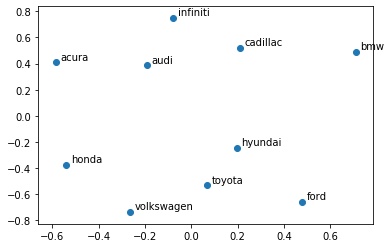

In [41]:
fig, ax = plt.subplots()
ax.scatter(mds_output['x'], mds_output['y'])
for brand in inverse_lift_brands.index.values:
    ax.text(mds_output.loc[brand, 'x']+0.02, mds_output.loc[brand, 'y']+0.02, brand)

##  <font color='red'>Task B: Insights</fonr>
TBD

What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

Audi has a very interesting association with the other top 9 brands. I would think that Audi has a strong association with the other luxury brands i.e. bmw, acura, infiniti, and cadillac. This seems to be the case but audi is also strongly associated with volkswagen. Maybe volkswagen is a luxury brand, but volkswagen is not strongly associated with the other mentioned luxury brands and is much more assocaited with the non-luxury japanese and american brands. This can be seen throught the MDS plot, Volkswagen is much more associated with ford, toyota, honda, and hyundai than the luxury brands. Maybe Volkswagen users want to upgrade to audis. 



## Task C
I went over 1500 words, picked and grouped words with intuition. 

Since professor said we don't have to do a sentiment analysis, I group positive and negative words together. For example, I grouped 'small' and 'large' into size attributes. 

Find 5 most frequently mentioned attributes.

In [18]:
word_frequency[:500]

car               3430
bmw               2551
wa                2300
like              2075
said              2054
one               2040
would             1965
audi              1911
ha                1733
get               1655
new               1508
think             1482
year              1348
even              1273
time              1188
good              1185
acura             1163
much              1132
well              1125
know              1070
really            1069
drive             1023
still              983
doe                983
could              978
make               973
price              973
honda              971
go                 925
also               922
better             915
dealer             897
see                855
thing              847
look               833
want               824
people             816
say                815
way                796
've                777
back               756
3                  741
model              721
going      

In [47]:
attribute_dict = { 
    'performance': ['drive', 'engine', 'sport', 'driving', 'performance', 'power', 'spped', 
                    'fast', 'faster', 'sporty', 'horsepower', 'powerful'],
    
    'fuel_efficiency': ['mile', 'mileage', 'oil', 'diesel', 'mpg', 'gas', 'fuel'],
    
    'look': ['look', 'nice', 'looking', 'design', 'nicer', 'style', 'attractive', 'designed', 'looked'],
    
    'luxury': ['great', 'brand', 'luxury', 'best', 'premium'],
    
    'reliability': ['issue', 'problem', 'recall', 'trouble', 'concerned', 'suspension', 'reliable',
                   'service', 'warranty', 'durability', 'quality'],
    
    'price': ['money', 'msrp', 'price', 'sale', 'offer', 'discount', 'bargain', 'grand', 'expensive',
             'cheap', 'cheaper', 'incentive', 'worth'],
    
    'size': ['big', 'huge', 'large', 'size', 'weight', 'bigger', 'sticker', 'roof',
            'little', 'small', 'light', 'smaller', 'biggest'],

    'interior': ['seat', 'interior', 'leather', 'steering', 'inside', 'radio', 'noise', 'quiet'],

    'experience': ['experience', 'speciall', 'interesting', 'impressive', 'surprised', 'amazing', 
                   'fun', 'happy', 'enthusiast'],
    
    'safety': ['safety', 'life', 'safe']}

## Task C: Find top 5 attributes

In [48]:
def count_attribute(df, attribute_terms):
    return(np.sum(df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1 )))

top_attributes = pd.DataFrame(pd.Series(attribute_dict), columns=['attribute_terms'])
top_attributes['count'] = top_attributes['attribute_terms'].map(lambda x: count_attribute(df, x))

top_attributes.sort_values(by=['count'], ascending=False)[:5]

,attribute_terms,count
performance,"[drive, engine, sport, driving, performance, p...",2646
price,"[money, msrp, price, sale, offer, discount, ba...",2259
look,"[look, nice, looking, design, nicer, style, at...",1863
size,"[big, huge, large, size, weight, bigger, stick...",1716
luxury,"[great, brand, luxury, best, premium]",1654


## Task C: Which attributes are most strongly associated with which of the top 5 brands?

In [21]:
def lift_attribute_to_brands(attribute, attribute_dict, brand_list, df):
    '''
    attribute is a string
    
    attribute_dict is the dictionary whose keys are attibutes and values are words(attribute_terms).
    
    df is the processed dataframe contains processed comments 
    '''
    attribute_terms = attribute_dict[attribute]
    output = dict()
    for brand in brand_list.index.values:
        df_a = df[df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)]
        N_a = df_a.shape[0] # count of comments w/ attribute
        N_b = sum(df['processed'].map(lambda x: brand in x)) # count of comments w/ brand
        N = df['processed'].shape[0]
        N_ab = sum(df_a['processed'].map(lambda x: brand in x)) # count of cooments w/ attribute and brand
        
        output[brand] = N*N_ab/(N_a*N_b)
        
    return(output)

In [49]:
brand_list = top10_brands[:5]

for attribute in top_attributes.index.values:
    print(attribute)
    output = lift_attribute_to_brands(attribute, attribute_dict, brand_list, df)
    output = pd.Series(output).sort_values(ascending=False)
    print(output)
    print('')

performance
audi        1.535607
bmw         1.508026
infiniti    1.471312
honda       1.410331
acura       1.366821
dtype: float64

fuel_efficiency
honda       1.631447
audi        1.424646
acura       1.369677
bmw         1.276385
infiniti    1.180158
dtype: float64

look
audi        1.629225
acura       1.596480
infiniti    1.591014
honda       1.586484
bmw         1.317249
dtype: float64

luxury
infiniti    2.130851
audi        1.908645
acura       1.856733
honda       1.819093
bmw         1.497805
dtype: float64

reliability
audi        1.778404
honda       1.563868
acura       1.523405
bmw         1.499618
infiniti    1.490724
dtype: float64

price
infiniti    1.827816
audi        1.701744
acura       1.597082
bmw         1.527069
honda       1.520163
dtype: float64

size
honda       1.778150
audi        1.743979
acura       1.569147
bmw         1.382496
infiniti    1.357784
dtype: float64

interior
audi        1.861030
honda       1.794344
infiniti    1.650337
acura       1.6439

## <font color='red'>Task D</font>
 TBD 

Task D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive). 

That the marketing/advertising team at bmw has done their job. When it comes to preformance, bmw is at the top, which is most likely becuase of their slogan "the ultimate driving machine." But maybe thats not enough. In all the other categories bmw is near or at the bottom especially when it comes to look and luxury. This seems to be a product manager problem. The product manager is not understanding what the consumer wants. The product and marketing managers need to work together to first change the design and image of bmw and then show customers that this attributes have imporved and are top notch. 

## Task E: The most aspirational brand 
### You can play around with different words by changing the words in the list below.

We can also try bigram, trigram if possible.

In [23]:
aspiration_dict = { 'aspiration': ['want', 'like', 'best', 'love', 'wanted', 'dream'] }

In [24]:
brand_list = top10_brands

output = lift_attribute_to_brands('aspiration', aspiration_dict, brand_list, df)
output = pd.Series(output).sort_values(ascending=False)
print(output)
print('')

infiniti      1.542057
audi          1.514346
toyota        1.497042
honda         1.468857
ford          1.445877
cadillac      1.430659
acura         1.413775
volkswagen    1.383032
bmw           1.372234
hyundai       1.353288
dtype: float64

